# 네이버 영화 리뷰 감성 분류
- LSTM 활용
- 출처: WikiDocs
- 데이터 다운로드 링크: https://github.com/e9t/nsmc/

In [ ]:
#한글분석을 위해 Konlpy설치
!pip install Konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 460kB 55.9MB/s 
     |████████████████████████████████| 92kB 14.8MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import konlpy
konlpy.__version__
#0.5.2

'0.5.2'

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
#파일업로드
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0] #ratings_train.txt

Saving ratings_train.txt to ratings_train.txt


In [ ]:
uploaded = files.upload()
testfile = list(uploaded.keys())[0] #ratings_test.txt

Saving ratings_test.txt to ratings_test.txt


## 데이터 전처리

In [ ]:
import pandas as pd
train_df= pd.read_table(filename)
test_df= pd.read_table(testfile)

In [ ]:
train_df.shape

(150000, 3)

In [ ]:
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [ ]:
#중복있는지 확인
train_df['document'].nunique()
#결과값:146182,2 (4천건정도중복인듯)

146182

In [ ]:
# document 열에서 중복인 내용이 있다면 중복제거 drop_duplicates
train_df.drop_duplicates(subset=['document'], inplace=True) 
train_df.shape
#중복제거했는데도 146182>146183로 1차이나는것은.. 널값이 있어서이다!

(146183, 3)

In [ ]:
#Null값확인
train_df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [ ]:
#Null값제거
train_df = train_df.dropna(how='any')
train_df.shape

(146182, 3)

In [ ]:
#긍정1 부정0 레이블값의 갯수
train_df.label.value_counts()

0    73342
1    72840
Name: label, dtype: int64

- 테스트 데이터 셋에도 마찬가지로 적용

In [ ]:
# 중복제거
test_df.drop_duplicates(subset=['document'], inplace=True) 
test_df.shape

(49158, 3)

In [ ]:
#Null값제거
test_df = test_df.dropna(how='any')
test_df.shape

(49157, 3)

## 한글텍스트전처리

In [ ]:
train_df['document'] = train_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 남겨놓고, 모두 제거 [^ㄱ-ㅎㅏ-ㅣ가-힣 ] 맨끝공백까지
train_df.head()
#공백. 즉, 띄어쓰기는 유지되면서 온점과 같은 구두점 등은 제거됨

In [ ]:
train_df['document'].replace('', np.nan, inplace=True) #아무것도없는데이터''
train_df.isnull().sum()
#391건이 영어거나, 구두점만있거나, 공백일것이다. 이것도지우자!!!

In [ ]:
train_df = train_df.dropna(how = 'any') # Null 값이 존재하는 행제거(널값제거)
train_df.shape

- 테스트데이터셋에도 적용

In [ ]:
test_df['document'] = test_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_df['document'].replace('', np.nan, inplace=True) #아무것도없는데이터''
test_df.isnull().sum()
#162건 영어거나, 구두점만있거나, 공백일것이다. 이것도지우자!!!

id            0
document    162
label         0
dtype: int64

In [ ]:
test_df = test_df.dropna(how = 'any') # Null 값이 존재하는 행제거(널값제거)
test_df.shape

(48995, 3)

### 한글형태소분석

In [ ]:
from konlpy.tag import Okt #형태소분석기
# 토큰화와 불용어 제거
import tqdm.notebook as tn
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

X_train=[]
for sentence in tn.tqdm(train_df['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 형태소분석morphs / 동사원형추출stem=True
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X) #스트링의 리스트로 바꾸는 작업

In [ ]:
X_test = []
for sentence in tn.tqdm(test_df['document']):
    morphs = okt.morphs(sentence, stem=True) # 한줄한줄데이터들어가서 토큰화(리스트만들어짐)/ 형태소분석기morphs
    temp_X = ' '.join([word for word in morphs if not word in stopwords]) # 불용어 제거
    X_test.append(temp_X)

In [ ]:
X_train[:3]

[['아', '더빙', '..', '진짜', '짜증나다', '목소리'],
 ['흠',
  '...',
  '포스터',
  '보고',
  '초딩',
  '영화',
  '줄',
  '....',
  '오버',
  '연기',
  '조차',
  '가볍다',
  '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

### 케라스인코딩

In [ ]:
#숫자로바꾸기 케라스인코딩을하기위한 정수인코딩
max_words = 35000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train[:3] #숫자로바뀌었다

[[56, 487, 4, 21, 280, 704],
 [963, 6, 488, 50, 649, 2, 233, 43, 1529, 29, 1013, 722, 26],
 [405, 2572, 27176, 5303, 6619, 3, 240, 14]]

### 리뷰길이 맞추기

In [ ]:
#전체 데이터의 길이 분포 패딩 몇길이 넣을지 해야하니까
print('리뷰의 최대 길이 :', max(len(s) for s in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 95
리뷰의 평균 길이 : 12.49924751337374


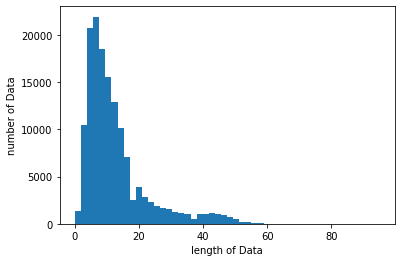

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show() #짧은단어가 많다...

In [ ]:
#  X_train과 X_test의 모든 샘플의 길이를 동일하게 30으로 셋팅(30이면 어느정도 커버되니까!)
max_len=30
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
y_train = train_df['label'].values
y_test = test_df['label'].values #전처리끝~~~~~~~~~~~~~~~~~~~

# 1)LSTM모델정의/설정/학습/평가0.8459

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [ ]:
model = Sequential([
                    Embedding(max_words, 100), #max_words35000을 100으로 줄여보자
                    LSTM(128),
                    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         3500000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,617,377
Trainable params: 3,617,377
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='naver-lstm-best-model.h5', monitor='val_loss', 
                               verbose=1, save_best_only=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=4, batch_size=60,
                    validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1950/1950 [==============================] - 77s 34ms/step - loss: 0.4269 - accuracy: 0.7939 - val_loss: 0.3324 - val_accuracy: 0.8557

Epoch 00001: val_loss improved from inf to 0.33242, saving model to naver-lstm-best-model.h5
Epoch 2/4
1950/1950 [==============================] - 64s 33ms/step - loss: 0.2697 - accuracy: 0.8881 - val_loss: 0.3285 - val_accuracy: 0.8601

Epoch 00002: val_loss improved from 0.33242 to 0.32848, saving model to naver-lstm-best-model.h5
Epoch 3/4
1950/1950 [==============================] - 64s 33ms/step - loss: 0.2077 - accuracy: 0.9169 - val_loss: 0.3556 - val_accuracy: 0.8596

Epoch 00003: val_loss did not improve from 0.32848
Epoch 4/4
1950/1950 [==============================] - 63s 32ms/step - loss: 0.1634 - accuracy: 0.9365 - val_loss: 0.3831 - val_accuracy: 0.8559

Epoch 00004: val_loss did not improve from 0.32848


In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('naver-lstm-best-model.h5')

In [ ]:
# 테스트 정확도
acc = best_model.evaluate(X_test, y_test, verbose=2)[1]
print(f"Accuracy:{acc:.4f}")
#Accuracy:0.8459

1532/1532 - 4s - loss: 0.3517 - accuracy: 0.8459
Accuracy:0.8459


In [ ]:

# 테스트셋
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
# 학습셋
y_loss = history.history['loss']
y_acc = history.history['accuracy']

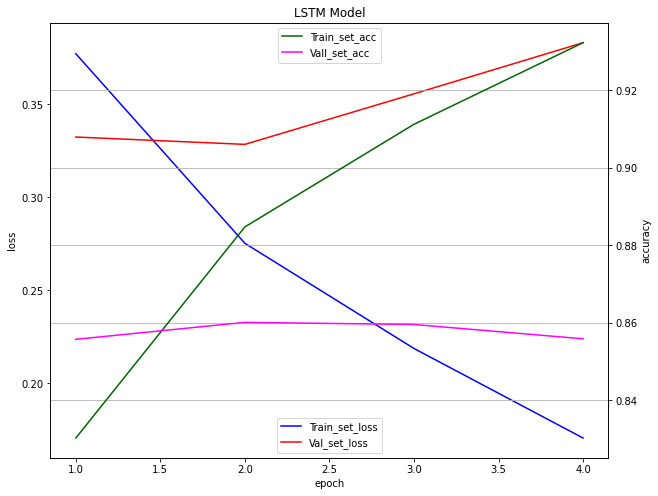

In [ ]:
x_len = np.arange(1, len(y_loss)+1)
fig, ax0 = plt.subplots(figsize=(10,8))
ax1 = ax0.twinx()
ax0.plot(x_len, y_loss, c="blue", label='Train_set_loss')
ax0.plot(x_len, y_vloss, c="red", label='Val_set_loss')
ax0.set_ylabel('loss')
ax1.plot(x_len, y_acc, c="darkgreen", label='Train_set_acc')
ax1.plot(x_len, y_vacc, c="magenta", label='Vall_set_acc')
ax1.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(loc='lower center')
ax1.legend(loc='upper center')
plt.title('LSTM Model')
plt.grid()
plt.show()

# 2)Simple RNN 모델정의/설정/학습/평가0.8350

In [ ]:
from tensorflow.keras.layers import SimpleRNN
model2 = Sequential([
                    Embedding(max_words, 100), #max_words35000을 100으로 줄여보자
                    SimpleRNN(128),
                    Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         3500000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               29312     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,529,441
Trainable params: 3,529,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='naver-rnn-best-model.h5', monitor='val_loss', 
                               verbose=1, save_best_only=True)
history2 = model2.fit(X_train, y_train, epochs=4, batch_size=60,
                    validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/4
1950/1950 [==============================] - 102s 52ms/step - loss: 0.4591 - accuracy: 0.7717 - val_loss: 0.3600 - val_accuracy: 0.8469

Epoch 00001: val_loss improved from inf to 0.35998, saving model to naver-rnn-best-model.h5
Epoch 2/4
1950/1950 [==============================] - 98s 50ms/step - loss: 0.2958 - accuracy: 0.8787 - val_loss: 0.3837 - val_accuracy: 0.8366

Epoch 00002: val_loss did not improve from 0.35998
Epoch 3/4
1950/1950 [==============================] - 98s 50ms/step - loss: 0.2086 - accuracy: 0.9190 - val_loss: 0.4732 - val_accuracy: 0.8114

Epoch 00003: val_loss did not improve from 0.35998
Epoch 4/4
1950/1950 [==============================] - 96s 49ms/step - loss: 0.1473 - accuracy: 0.9466 - val_loss: 0.4952 - val_accuracy: 0.8182

Epoch 00004: val_loss did not improve from 0.35998


In [ ]:
best_model = load_model('naver-rnn-best-model.h5')
acc = best_model.evaluate(X_test, y_test, verbose=2)[1]
print(f"Accuracy:{acc:.4f}")
#Accuracy:0.8350

1532/1532 - 5s - loss: 0.3762 - accuracy: 0.8350
Accuracy:0.8350


# 3)LSTM+CNN 모델정의/설정/학습/평가0.7725

In [ ]:
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D
# Conv1D 와 LSTM 모델
model3 = Sequential([
                    Embedding(max_words, 100),
                    Dropout(0.5),
                    Conv1D(64, 5, padding='valid', activation='relu'),
                    MaxPooling1D(pool_size=4),
                    LSTM(60),
                    Dense(1, activation='sigmoid')
])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         3500000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                30000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 3,562,125
Trainable params: 3,562,125
Non-trainable params: 0
____________________________________________

In [ ]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='naver-cnn-best-model.h5', monitor='val_loss', 
                               verbose=1, save_best_only=True)
history3 = model3.fit(X_train, y_train, epochs=5, batch_size=60,
                    validation_split=0.2, verbose=1, callbacks=[checkpointer])

Epoch 1/5
1950/1950 [==============================] - 62s 31ms/step - loss: 0.5132 - accuracy: 0.7233 - val_loss: 0.4157 - val_accuracy: 0.8032

Epoch 00001: val_loss improved from inf to 0.41571, saving model to naver-cnn-best-model.h5
Epoch 2/5
1950/1950 [==============================] - 60s 31ms/step - loss: 0.3694 - accuracy: 0.8304 - val_loss: 0.4100 - val_accuracy: 0.8052

Epoch 00002: val_loss improved from 0.41571 to 0.41004, saving model to naver-cnn-best-model.h5
Epoch 3/5
1950/1950 [==============================] - 60s 31ms/step - loss: 0.3140 - accuracy: 0.8575 - val_loss: 0.4315 - val_accuracy: 0.8076

Epoch 00003: val_loss did not improve from 0.41004
Epoch 4/5
1950/1950 [==============================] - 60s 31ms/step - loss: 0.2758 - accuracy: 0.8763 - val_loss: 0.4421 - val_accuracy: 0.8002

Epoch 00004: val_loss did not improve from 0.41004
Epoch 5/5
1950/1950 [==============================] - 59s 30ms/step - loss: 0.2437 - accuracy: 0.8910 - val_loss: 0.4703 - va

In [ ]:
best_model = load_model('naver-cnn-best-model.h5')
acc = best_model.evaluate(X_test, y_test, verbose=2)[1]
print(f"Accuracy:{acc:.4f}")

1532/1532 - 3s - loss: 0.4534 - accuracy: 0.7725
Accuracy:0.7725
